In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

from statistics import mean

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5),(0.5))])

trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = T.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset    = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = T.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
### Helper functions
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

    
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [4]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.input_layer = nn.Conv2d(1,28,kernel_size=7)
        self.conv1 = nn.Conv2d(28, 56, 7)
        self.conv2 = nn.Conv2d(56,112,7)
        self.drop = nn.Dropout2d(0.1)
        self.layer1 = nn.Linear(112*10*10,60)
        self.layer2 = nn.Linear(60,30)
        self.layer3 = nn.Linear(30,10)

    def forward(self, x):
        x = F.relu(self.drop(self.input_layer(x)))
        x = F.relu(self.drop(self.conv1(x)))
        x = F.relu(self.drop(self.conv2(x)))
        #print(x.shape)
        x = x.view(x.shape[0], -1)
        #print(x.shape)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        out_layer = self.layer3(x)
        return out_layer


In [5]:
model = Classifier()

In [6]:
model

Classifier(
  (input_layer): Conv2d(1, 28, kernel_size=(7, 7), stride=(1, 1))
  (conv1): Conv2d(28, 56, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(56, 112, kernel_size=(7, 7), stride=(1, 1))
  (drop): Dropout2d(p=0.1, inplace=False)
  (layer1): Linear(in_features=11200, out_features=60, bias=True)
  (layer2): Linear(in_features=60, out_features=30, bias=True)
  (layer3): Linear(in_features=30, out_features=10, bias=True)
)

In [7]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [8]:
epochs = 10
print_every = 40
final_trl = []
final_tel =[]
final_accuracy = []


for e in range(epochs):
    running_loss = 0
    total=0
    correct=0
    train_losses = []
    test_losses = []
    epoch_accurracy =[]
    print(f"Epoch: {e+1}/{epochs}")

    for i, (images, labels) in enumerate(iter(trainloader)):


        
        optimizer.zero_grad()
        
        logits = model.forward(images)   # 1) Forward pass
        pred = F.log_softmax(logits, dim=1)
        loss = criterion(pred, labels) # 2) Compute loss
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += loss.item()

        train_losses.append(loss.item())
        
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0

    
    model.eval()
    with T.no_grad():
        for i, (images, labels) in enumerate(iter(testloader)):

            logits = model.forward(images)
            test_pred = F.log_softmax(logits, dim=1)

            test_loss = criterion(test_pred, labels)

            test_losses.append(test_loss.item())

            _,predicted = test_pred.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            accuracy = 100*correct/total


            epoch_accurracy.append(accuracy)


            



    model.train()
    
    mean_trl = mean(train_losses)
    mean_tel = mean(test_losses)
    mean_acc = mean(epoch_accurracy)
    final_trl.append(mean_trl)
    final_tel.append(mean_tel)
    final_accuracy.append(mean_acc)
    
    if (e+1) % 1 == 0:
        T.save(model.state_dict(), f'checkpoint_{e+1}.pth')

    #accuracies.append(acc)
    print(f'Epoch: {e + 1} | loss: {mean_trl} | test loss: {mean_tel} | accuracy:{mean_acc} ')

Epoch: 1/10
	Iteration: 0	 Loss: 0.0577
	Iteration: 40	 Loss: 2.3045
	Iteration: 80	 Loss: 2.3068
	Iteration: 120	 Loss: 2.3045
	Iteration: 160	 Loss: 2.2983
	Iteration: 200	 Loss: 2.2989
	Iteration: 240	 Loss: 2.2989
	Iteration: 280	 Loss: 2.2958
	Iteration: 320	 Loss: 2.2942
	Iteration: 360	 Loss: 2.2877
	Iteration: 400	 Loss: 2.2891
	Iteration: 440	 Loss: 2.2855
	Iteration: 480	 Loss: 2.2813
	Iteration: 520	 Loss: 2.2684
	Iteration: 560	 Loss: 2.2589
	Iteration: 600	 Loss: 2.2394
	Iteration: 640	 Loss: 2.2172
	Iteration: 680	 Loss: 2.1701
	Iteration: 720	 Loss: 2.1044
	Iteration: 760	 Loss: 1.9445
	Iteration: 800	 Loss: 1.7088
	Iteration: 840	 Loss: 1.4226
	Iteration: 880	 Loss: 1.1179
	Iteration: 920	 Loss: 0.9804
Epoch: 1 | loss: 2.064107415073716 | test loss: 0.8475244417312039 | accuracy:72.32855582252765 
Epoch: 2/10
	Iteration: 0	 Loss: 0.0232
	Iteration: 40	 Loss: 0.8560
	Iteration: 80	 Loss: 0.7377
	Iteration: 120	 Loss: 0.7076
	Iteration: 160	 Loss: 0.6731
	Iteration: 200	 

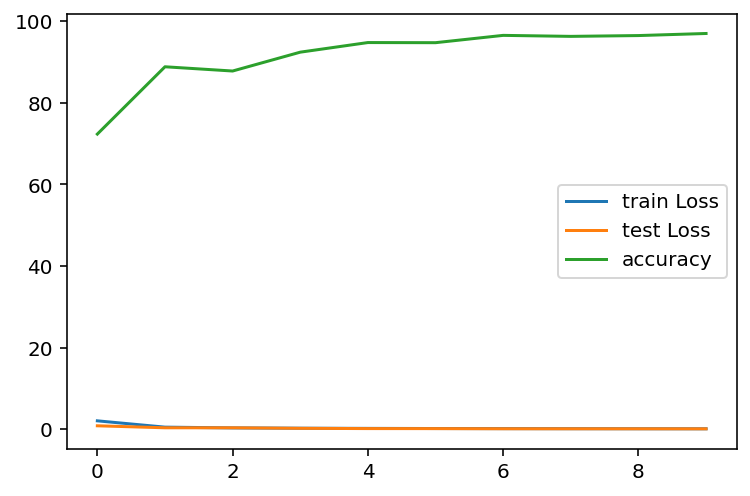

In [9]:
plt.plot(final_trl, label='train Loss')
plt.plot(final_tel, label='test Loss')
plt.plot(final_accuracy, label='accuracy')
plt.legend()
plt.show()

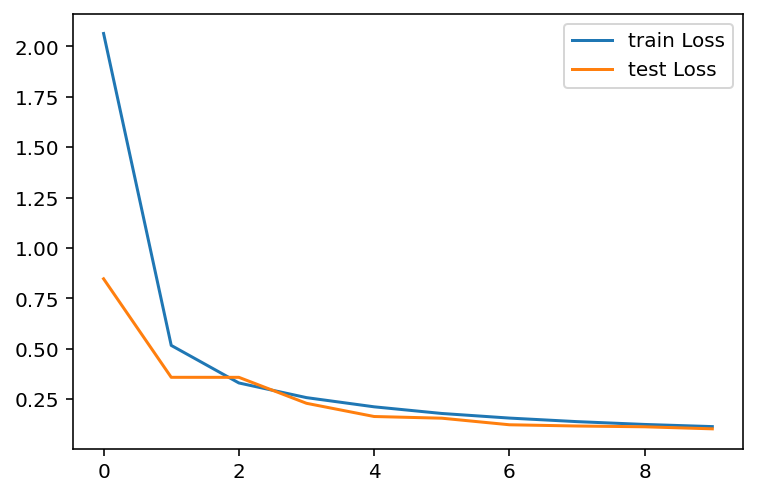

In [10]:
plt.plot(final_trl, label='train Loss')
plt.plot(final_tel, label='test Loss')
#plt.plot(final_accuracy, label='accuracy')
plt.legend()
plt.show()

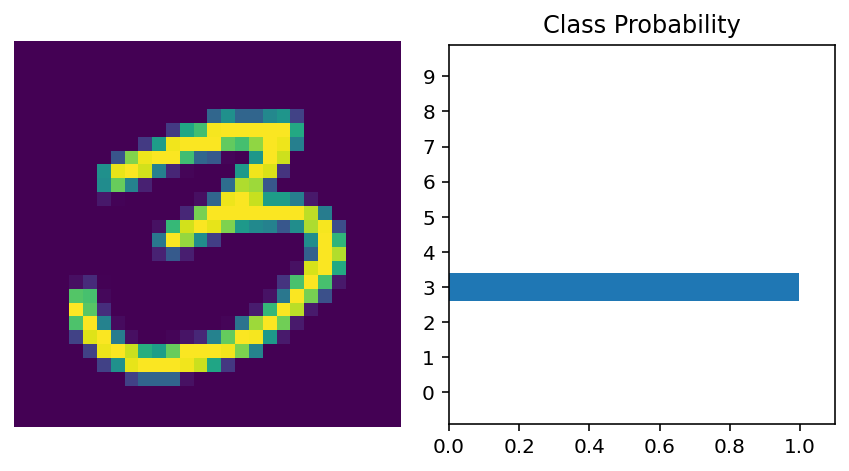

In [24]:
images, labels = next(iter(testloader))

img = images[5][None]
img = img.type('torch.FloatTensor')
# Turn off gradients to speed up this part
with T.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)

view_classify(img, ps, version='MNIST')